In [33]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [34]:
df = pd.read_csv('WineQT.csv')

In [35]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


# Träna en random forest:

Jag tar bort id då det inte kommer ge något till modellen.

In [36]:
X = df.drop(columns=['Id','quality'], axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Din ursprungliga klassificerare
clf = RandomForestClassifier(random_state=42)

# Parametrarna du vill söka över
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Skapa Grid Search-objektet
grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=3, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Använd den bästa modellen för att göra förutsägelser
best_clf = grid_search.best_estimator_
# Skriv ut de bästa parametrarna
print(grid_search.best_params_)
print("Test score: ", best_clf.score(X_test, y_test))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.678 total time=   0.1s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.645 total time=   0.1s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.577 total time=   0.2s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.661 total time=   0.1s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.672 total time=   0.2s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.634 total time=   0.3s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.689 total time=   0.3s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0

# Vad får modellen för testscore?

In [38]:
y_pred = best_clf.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print(f'Test Score: {test_score}')

Test Score: 0.7030567685589519


# Hur många träd finns det i skogen?

In [39]:
n_trees = len(best_clf.estimators_)
print(f'Antal träd: {n_trees}')

Antal träd: 300


# Vilka attribut har störst påverkan?

In [40]:
importances = best_clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

print("Attribut med störst påverkan:")
for index in sorted_indices:
    print(f"{X.columns[index]}: {importances[index]}")

Attribut med störst påverkan:
alcohol: 0.14343425134358986
sulphates: 0.12095233518963655
volatile acidity: 0.10912877044449085
total sulfur dioxide: 0.09763467615767579
density: 0.08945734212834261
chlorides: 0.08430743146837169
pH: 0.074455409961004
fixed acidity: 0.07387066581136431
citric acid: 0.07342214360705251
free sulfur dioxide: 0.06736563489799746
residual sugar: 0.0659713389904745


# Vilka klasser är det den modellen har störst problem med att klassificera rätt? Varför är det problem med de klasserna?

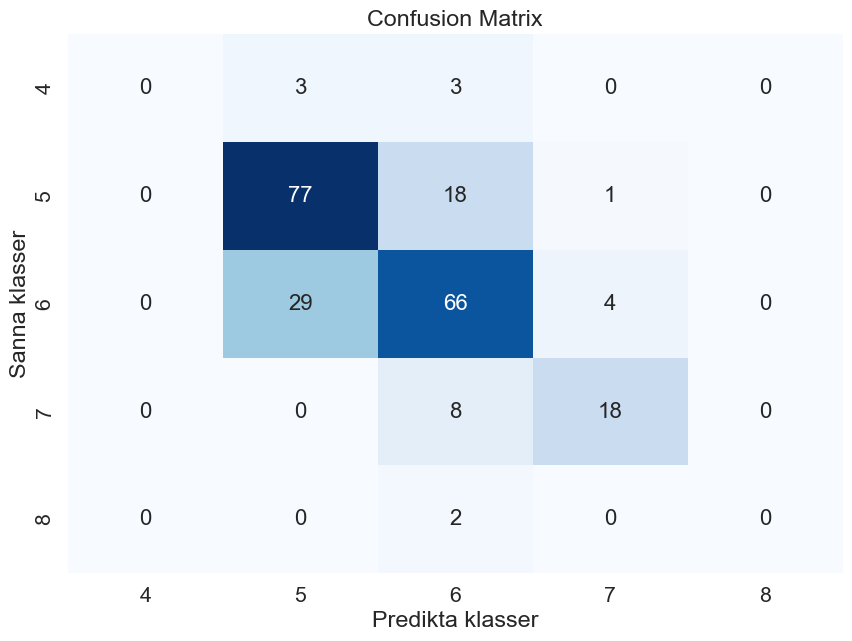

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Beräkna confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[4, 5, 6, 7, 8])  # Vi specifierar labels för att säkerställa rätt ordning

plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=[4, 5, 6, 7, 8], yticklabels=[4, 5, 6, 7, 8])  # Lägg till xticklabels och yticklabels
plt.xlabel('Predikta klasser')
plt.ylabel('Sanna klasser')
plt.title('Confusion Matrix')
plt.show()


Moddelen har problem med att klassificera klass 4 korrekt eftersom den inte har några korrekta prediktioner för den klassen. Alla observationer för klass 4 förväxlas med 5 och 6. Kan bero på att klass 4 har få observationer i datasetet. Modellen har också problem med att korrekt klassificera klass 8, alla observationer misstas som klass 6. Detta kan också bero på att klass 4 har få observationer i datasetet. För klasser 4, 5 och 6 verkar modellen ha vissa problem med att skilja dem åt. För klass 7 har de flesta observationerna klassificeras korrekt men ett visst antal misstas för klass 6. Det finns ett betydande antal observationer som förväxlas mellan klass 4 och 5, samt mellan klass 5 och 6. Detta kan bero på att dessa klasser har liknande egenskaper, vilket gör det svårare för modellen att skilja dem åt.

För att förbättra modellens prestanda kan man prova att samla mer data för underrepresenterade klasser, justera modellparametrar, använda en annan algoritm eller prova tekniker för att hantera obalanserade klasser, som att använda viktning eller översampling/undersampling.

# Bygg en egen random forest genom att träna flera decision trees.

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy import stats

# Definiera parameterrutnätet
n_trees_grid = [10, 50, 100, 200, 500]
max_features_grid = ['sqrt', None, 0.5, 'log2']
min_samples_split_grid = [2, 10, 50]
min_samples_leaf_grid = [1, 5, 20]
max_depth_grid = [None, 10, 50, 100]

# Håll reda på bästa scoren
best_score = 0
best_params = None

# Loopa igenom alla kombinationer av parametrar
for n_trees in n_trees_grid:
    for max_features in max_features_grid:
        for min_samples_split in min_samples_split_grid:
            for min_samples_leaf in min_samples_leaf_grid:
                for max_depth in max_depth_grid:

                    # Skapa listor för att lagra träd och förutsägelser
                    trees = []
                    predictions = []

                    # Träna varje träd
                    for i in range(n_trees):
                        X_train_sample, y_train_sample = resample(X_train, y_train, random_state=i)
                        tree = DecisionTreeClassifier(max_features=max_features, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=i)
                        tree.fit(X_train_sample, y_train_sample)
                        trees.append(tree)
                        y_pred = tree.predict(X_test)
                        predictions.append(y_pred)

                    # Gör en majoritetsröstning för att få slutgiltiga förutsägelser
                    y_pred_majority = stats.mode(predictions, axis=0, keepdims=True).mode[0]

                    # Beräkna testscoren
                    test_score = accuracy_score(y_test, y_pred_majority)
                    print(f"Testscore för n_trees={n_trees}, max_features={max_features}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, max_depth={max_depth}: {test_score}")

                    # Uppdatera bästa scoren och parametrarna om detta är bättre än tidigare bästa
                    if test_score > best_score:
                        best_score = test_score
                        best_params = (n_trees, max_features, min_samples_split, min_samples_leaf, max_depth)

print(f"Bästa testscoren: {best_score} med parametrar n_trees={best_params[0]}, max_features={best_params[1]}, min_samples_split={best_params[2]}, min_samples_leaf={best_params[3]}, max_depth={best_params[4]}")


Testscore för n_trees=10, max_features=sqrt, min_samples_split=2, min_samples_leaf=1, max_depth=None: 0.6724890829694323
Testscore för n_trees=10, max_features=sqrt, min_samples_split=2, min_samples_leaf=1, max_depth=10: 0.6506550218340611
Testscore för n_trees=10, max_features=sqrt, min_samples_split=2, min_samples_leaf=1, max_depth=50: 0.6724890829694323
Testscore för n_trees=10, max_features=sqrt, min_samples_split=2, min_samples_leaf=1, max_depth=100: 0.6724890829694323
Testscore för n_trees=10, max_features=sqrt, min_samples_split=2, min_samples_leaf=5, max_depth=None: 0.6462882096069869
Testscore för n_trees=10, max_features=sqrt, min_samples_split=2, min_samples_leaf=5, max_depth=10: 0.6550218340611353
Testscore för n_trees=10, max_features=sqrt, min_samples_split=2, min_samples_leaf=5, max_depth=50: 0.6462882096069869
Testscore för n_trees=10, max_features=sqrt, min_samples_split=2, min_samples_leaf=5, max_depth=100: 0.6462882096069869
Testscore för n_trees=10, max_features=sqr

# Hur många träd har du i skogen?

In [46]:
print(f"Antal träd: {best_params[0]}")


Antal träd: 50


# Vad får du för testscore? Skiljer den sig mot modellen du skapade i godkänt
# delen? I så fall, varför tror du den skiljer sig?

I godkänt delen fick jag 0.7030567685589519 som test score och nu fick jag 0.6812227074235808. Skillnaden kanske blir på grund av att de är olika metoder. Dessutom om en modell överanpassar till träningsdata kan det leda till högre prestanda på träningsdata men sämre prestanda på testdata. Om det har varit olika nivåer av överanpassning i modellerna kan detta ha påverkat resultaten.

# Vilka klasser har modellen problem med? Är det samma klasser som för
# modellen i godkänt delen?

[[ 0  2  4  0  0]
 [ 0 75 18  3  0]
 [ 0 43 47  9  0]
 [ 0  3 16  7  0]
 [ 0  0  2  0  0]]


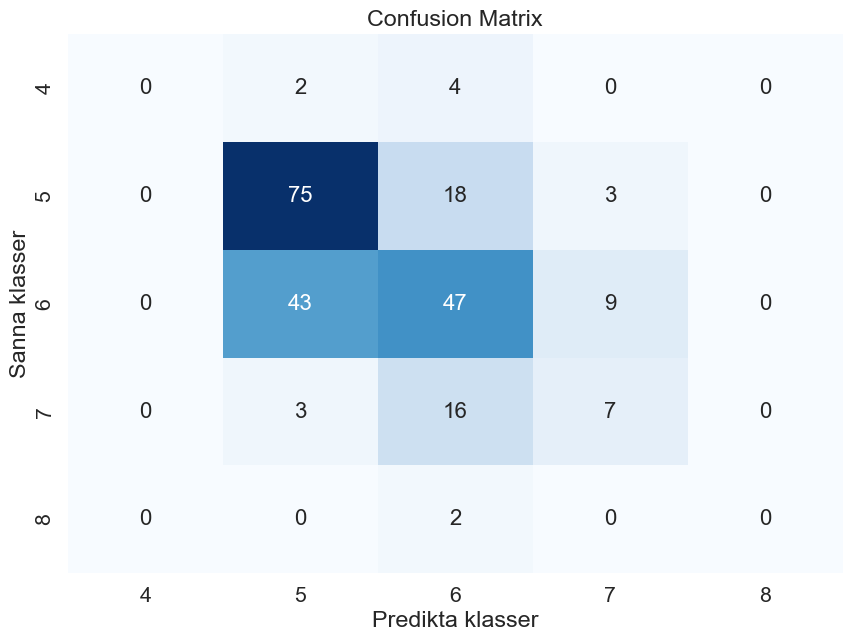

In [51]:
# Beräkna confusion matrix
y_pred_best = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[4, 5, 6, 7, 8])  # Vi specifierar labels för att säkerställa rätt ordning
print(cm)
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=[4, 5, 6, 7, 8], yticklabels=[4, 5, 6, 7, 8])  # Lägg till xticklabels och yticklabels
plt.xlabel('Predikta klasser')
plt.ylabel('Sanna klasser')
plt.title('Confusion Matrix')
plt.show()

Confusion-matrisen indikerar att modellen har svårigheter med klasserna 4, 7 och 8. Alla instanser av klass 4 och 8 felklassificeras, medan endast cirka en fjärdedel av instanserna för klass 7 korrekt klassificeras. Även om klass 5 och 6 hanteras relativt bättre, finns det fortfarande en betydande felklassificering mellan dessa två klasser.

# Utmaning (krävs ej för godkänt eller väl godkänt):
# Vad är den bästa score du kan få, både för för random forest för sklearn och för din
# egenbyggda skog?